## import library and load Data

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pyswarms as ps
from deap import base, creator, tools, algorithms
import warnings
warnings.filterwarnings('ignore')

In [64]:
train_df = pd.read_csv('loan_train.csv')
test_df = pd.read_csv('loan_test.csv')

print(f"Row Number Train: {train_df.shape[0]}")
print(f"Row Number Test: {test_df.shape[0]}")
print(f"Columns :\n{train_df.columns.tolist()}")

Row Number Train: 614
Row Number Test: 367
Columns :
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term', 'Credit_History', 'Area', 'Status']


## Data Preprocessing

In [65]:
def preprocess_data(train_data, test_data):
    """
    Data Preprocessing:
    1. NAN Delete
    2. Converting nominal variables to numeric with LabelEncoder
    """
    
    # Copy Data
    train = train_data.copy()
    test = test_data.copy()
    
    print(f"\n Number of NaN before deletion:")
    print(train.isnull().sum())
    
    # Delete rows with NaN
    
    train_clean = train.dropna()
    test_clean = test.dropna()
    
    
    # Nominal columns to be converted
    categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Area', 'Status']
    
    label_encoders = {}
    
    for col in categorical_columns:
        if col in train_clean.columns:
            le = LabelEncoder()
            
            # for Train
            train_clean[col] = le.fit_transform(train_clean[col].astype(str))
            
            # for test
            
            if col in test_clean.columns:
                # Use learned_classes on train
                # If it is a new value, it will be converted to NaN
                test_clean[col] = test_clean[col].map(
                    lambda x: le.transform([str(x)])[0] if str(x) in le.classes_ else -1
                )
                
                label_encoders[col] = le
                mapping = dict(zip(le.classes_, le.transform(le.classes_)))
                print(f"{col} mapping: {mapping}")
                
    if 'Dependents' in train_clean.columns:
        train_clean['Dependents'] = train_clean['Dependents'].replace('3+', '3').astype(float)
    if 'Dependents' in test_clean.columns:
        test_clean['Dependents'] = test_clean['Dependents'].replace('3+', '3').astype(float)
    return train_clean, test_clean, label_encoders

In [66]:
train_processed, test_processed, encoders = preprocess_data(train_df, test_df)



 Number of NaN before deletion:
Gender                13
Married                3
Dependents            15
Education              0
Self_Employed         32
Applicant_Income       0
Coapplicant_Income     0
Loan_Amount            0
Term                  14
Credit_History        50
Area                   0
Status                 0
dtype: int64
Gender mapping: {'Female': np.int64(0), 'Male': np.int64(1)}
Married mapping: {'No': np.int64(0), 'Yes': np.int64(1)}
Education mapping: {'Graduate': np.int64(0), 'Not Graduate': np.int64(1)}
Self_Employed mapping: {'No': np.int64(0), 'Yes': np.int64(1)}
Area mapping: {'Rural': np.int64(0), 'Semiurban': np.int64(1), 'Urban': np.int64(2)}


In [67]:
# Separating features and labels

X_train = train_processed.drop('Status', axis=1)
y_train = train_processed['Status']

if 'Status' in test_processed.columns:
    X_test = test_processed.drop('Status', axis=1)
    y_test = test_processed['Status']
else:
    X_test = test_processed.copy()
    y_test = None

In [68]:
print("Data ready for model:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

for i, col in enumerate(X_train.columns):
    print(f"  {i}: {col}")

print(f"\n Label distribution:")
print(y_train.value_counts())


Data ready for model:
X_train shape: (499, 11)
y_train shape: (499,)
X_test shape: (293, 11)
  0: Gender
  1: Married
  2: Dependents
  3: Education
  4: Self_Employed
  5: Applicant_Income
  6: Coapplicant_Income
  7: Loan_Amount
  8: Term
  9: Credit_History
  10: Area

 Label distribution:
Status
1    341
0    158
Name: count, dtype: int64


## PSO implementation

In [71]:
class PSO_FeatureSelection:
    """
    Feature selection using PSO algorithm
    """
    def __init__(self, X_train, y_train, X_test, y_test, alpha=0.99):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.alpha = alpha
        self.n_features = X_train.shape[1]
        
        self.fitness_history = []
        self.best_fitness_history = []
        self.selected_features_history = []
        
    def fitness_function(self, particles):
        """
        Fitness function for PSO

        J = α(1 - Acc) + (1 - α)(1 - n_selected/n_total)

        Objective: Minimize J (which is equivalent to maximizing 
        accuracy and minimizing the number of features)
        """
        fitness_values = []
        
        for particle in particles:
        # Convert to binary (threshold = 0.5)
            binary_particle = (particle > 0.5).astype(int)
            
            # If no features are selected, give bad fitness
            if binary_particle.sum() == 0:
                fitness_values.append(1.0)
                continue
            
            # Select features
            selected_indices = np.where(binary_particle == 1)[0]
            X_train_selected = self.X_train.iloc[:, selected_indices]
            X_test_selected = self.X_test.iloc[:, selected_indices]
            
            # Training the Random Forest model
            rf = RandomForestClassifier(n_estimators=50, random_state=33, n_jobs=-1)
            rf.fit(X_train_selected, self.y_train)
            
            # Calculation accuracy
            y_pred = rf.predict(X_test_selected)
            accuracy = accuracy_score(self.y_test, y_pred)
            
            # Calculate the ratio of selected features
            feature_ratio = binary_particle.sum() / self.n_features
            
            # Calculate the fitness function
            fitness = self.alpha * (1 - accuracy) + (1 - self.alpha) * feature_ratio
            
            fitness_values.append(fitness)
        
        return np.array(fitness_values)
    
    def optimize(self, n_particles=50, n_iterations=100, verbose=True):
        """
        Implementing the PSO algorithm
        
        Parameters:
        -----------
        n_particles: number of particles
        n_iterations: Number of iterations
        verbose: show progress
        """
 
        print(f"Number of particles: {n_particles}")
        print(f"Number of repetitions: {n_iterations}")
        print(f"Number of features: {self.n_features}")
        print(f"Alpha (accuracy weight): {self.alpha}")
        
        # PSO Setting
        options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
        
        # Create optimizer
        optimizer = ps.single.GlobalBestPSO(
            n_particles=n_particles,
            dimensions=self.n_features,
            options=options,
            bounds=(np.zeros(self.n_features), np.ones(self.n_features))
        )
        
        # Optimization
        best_cost, best_pos = optimizer.optimize(
            self.fitness_function,
            iters=n_iterations,
            verbose=verbose
        )
        
        # Save history
        self.fitness_history = optimizer.cost_history
        
        # Convert best position to binary
        best_features = (best_pos > 0.5).astype(int)
        selected_indices = np.where(best_features == 1)[0]
        
        # Calculating the final accuracy
        X_train_selected = self.X_train.iloc[:, selected_indices]
        X_test_selected = self.X_test.iloc[:, selected_indices]
        
        rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf.fit(X_train_selected, self.y_train)
        y_pred = rf.predict(X_test_selected)
        final_accuracy = accuracy_score(self.y_test, y_pred)
        

        print(f" Best Fitness: {best_cost:.6f}")
        print(f"Ultimate accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
        print(f"Number of selected features: {len(selected_indices)}/{self.n_features}")
        print(f"\nSelected features:")
        for idx in selected_indices:
            print(f"{self.X_train.columns[idx]}")
        
        return {
            'best_features': best_features,
            'selected_indices': selected_indices,
            'selected_feature_names': self.X_train.columns[selected_indices].tolist(),
            'best_fitness': best_cost,
            'final_accuracy': final_accuracy,
            'n_selected': len(selected_indices),
            'fitness_history': self.fitness_history
        }

***Run PSO***

In [72]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=33)
pso_selector = PSO_FeatureSelection(
    X_train_, y_train_, X_val, y_val, alpha=0.99
)

pso_results = pso_selector.optimize(
    n_particles=50,
    n_iterations=100,
    verbose=True
)

2026-02-01 19:17:51,736 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Number of particles: 50
Number of repetitions: 100
Number of features: 11
Alpha (accuracy weight): 0.99


pyswarms.single.global_best:   0%|          |0/100

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.177
2026-02-01 19:30:21,985 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.17705454545454546, best pos: [0.54886542 0.15871635 0.44566087 0.35927389 0.44676989 0.74753723
 0.41529876 0.76168335 0.6984333  0.70222312 0.60061875]


 Best Fitness: 0.177055
Ultimate accuracy: 0.8133 (81.33%)
Number of selected features: 6/11

Selected features:
Gender
Applicant_Income
Loan_Amount
Term
Credit_History
Area


## GA Implementation

In [81]:
class GA_FeatureSelection:
    """
    Feature selection using Genetic Algorithm (GA)
    """
    
    def __init__(self, X_train, y_train, X_test, y_test, alpha=0.99):
 
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.alpha = alpha
        self.n_features = X_train.shape[1]
        
        self.fitness_history = []
        self.best_fitness_history = []
        
    def evaluate_individual(self, individual):
        """
        Evaluation of a person
        
        Returns:

        fitness: tuple with one element (for DEAP)
        """
        # Convert to numpy array
        selected_features = np.array(individual)
        
        # If no feature is selected
        if selected_features.sum() == 0:
            return (1.0,) 
        
        # Select features
        selected_indices = np.where(selected_features == 1)[0]
        X_train_selected = self.X_train.iloc[:, selected_indices]
        X_test_selected = self.X_test.iloc[:, selected_indices]
        
        # Model training
        rf = RandomForestClassifier(n_estimators=50, random_state=33, n_jobs=-1)
        rf.fit(X_train_selected, self.y_train)
        
        # predict and calculating accuracy
        y_pred = rf.predict(X_test_selected)
        accuracy = accuracy_score(self.y_test, y_pred)
        
        # Calculating the feature ratio
        feature_ratio = selected_features.sum() / self.n_features
        
        # Fitness calculation
        fitness = self.alpha * (1 - accuracy) + (1 - self.alpha) * feature_ratio
        
        return (fitness,)
    
    def optimize(self, pop_size=50, n_generations=50, cx_prob=0.7, mut_prob=0.2, verbose=True):
        """
        
        Parameters:
        -----------
        pop_size: Population size
        n_generations: Number of generations
        cx_prob: Crossover probability
        mut_prob: Mutation probability
        verbose: Show progress
        """

        print(f"Population size: {pop_size}")
        print(f"Number of generations: {n_generations}")
        print(f"Crossover probability: {cx_prob}")
        print(f"Mutation probability: {mut_prob}")
        print(f"Number of features: {self.n_features}")
        print(f"Alpha (accuracy weight): {self.alpha}")
        
        # DEAP Setting
        if hasattr(creator, "FitnessMin"):
            del creator.FitnessMin
        if hasattr(creator, "Individual"):
            del creator.Individual
            
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)
        
        toolbox = base.Toolbox()
        
        # Gene creation (0 or 1)
        toolbox.register("attr_bool", np.random.randint, 0, 2)
        
        # Create Person
        toolbox.register("individual", tools.initRepeat, creator.Individual,
                        toolbox.attr_bool, n=self.n_features)
        
        # Create a crowd
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        
        # Register operators
        toolbox.register("evaluate", self.evaluate_individual)
        toolbox.register("mate", tools.cxTwoPoint)  # Two-Point Crossover
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)  # Bit Flip Mutation
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        # Create the initial population
        population = toolbox.population(n=pop_size)
        
        # Statistics
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("min", np.min)
        stats.register("max", np.max)
        
        # Hall of Fame 
        hof = tools.HallOfFame(1)
        
        # Run the algorithm
        for gen in range(n_generations):
            # Population assessment
            fitnesses = list(map(toolbox.evaluate, population))
            for ind, fit in zip(population, fitnesses):
                ind.fitness.values = fit
            
            # Save statistics
            record = stats.compile(population)
            self.fitness_history.append(record['min'])
            
            # Show progress
            # if verbose and (gen % 10 == 0 or gen == n_generations - 1):
            #     print(f"نسل {gen+1:3d}/{n_generations} | "
            #           f"Best Fitness: {record['min']:.6f} | "
            #           f"Avg: {record['avg']:.6f}")
            
            # Hall of Fame Update
            hof.update(population)
            
            # select
            offspring = toolbox.select(population, len(population))
            offspring = list(map(toolbox.clone, offspring))
            
            # Crossover
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < cx_prob:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            
            # Mutation
            for mutant in offspring:
                if np.random.random() < mut_prob:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            
            # Replacement
            population[:] = offspring
        
        # The best person
        best_individual = hof[0]
        best_features = np.array(best_individual)
        selected_indices = np.where(best_features == 1)[0]
        
        # Calculating the final accuracy
        X_train_selected = self.X_train.iloc[:, selected_indices]
        X_test_selected = self.X_test.iloc[:, selected_indices]
        
        rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf.fit(X_train_selected, self.y_train)
        y_pred = rf.predict(X_test_selected)
        final_accuracy = accuracy_score(self.y_test, y_pred)
        

        print(f"Best Fitness: {best_individual.fitness.values[0]:.6f}")
        print(f"Final Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
        print(f"Number of selected features: {len(selected_indices)}/{self.n_features}")
        print(f"\n Selected features:")
        for idx in selected_indices:
            print(f"{self.X_train.columns[idx]}")

        
        return {
            'best_features': best_features,
            'selected_indices': selected_indices,
            'selected_feature_names': self.X_train.columns[selected_indices].tolist(),
            'best_fitness': best_individual.fitness.values[0],
            'final_accuracy': final_accuracy,
            'n_selected': len(selected_indices),
            'fitness_history': self.fitness_history
        }


In [ ]:
# اجرای GA
ga_selector = GA_FeatureSelection(
    X_train_, y_train_, X_val, y_val, alpha=0.99
)

ga_results = ga_selector.optimize(
    pop_size=50,
    n_generations=50,
    cx_prob=0.9,
    mut_prob=0.1,
    verbose=True
)

Population size: 50
Number of generations: 50
Crossover probability: 0.9
Mutation probability: 0.1
Number of features: 11
Alpha (accuracy weight): 0.99
Best Fitness: 0.192073
Final Accuracy: 0.7933 (79.33%)
Number of selected features: 8/11

 Selected features:
Gender
Married
Dependents
Education
Applicant_Income
Loan_Amount
Term
Credit_History


## Comparison of PSO and GA results

In [75]:

def compare_algorithms(pso_results, ga_results, feature_names):
    """
   Full comparison of PSO and GA results
    """
    
    # Comparison table
    comparison_data = {
        'Criteria': [
        'Final Accuracy (%)',
        'Number of Features Selected',
        'Feature Reduction Ratio (%)',
        'Best Fitness',
        'Number of Repetitions'
        ],
        'PSO': [
            f"{pso_results['final_accuracy']*100:.2f}",
            f"{pso_results['n_selected']}/{len(feature_names)}",
            f"{(1 - pso_results['n_selected']/len(feature_names))*100:.2f}",
            f"{pso_results['best_fitness']:.6f}",
            len(pso_results['fitness_history'])
        ],
        'GA': [
            f"{ga_results['final_accuracy']*100:.2f}",
            f"{ga_results['n_selected']}/{len(feature_names)}",
            f"{(1 - ga_results['n_selected']/len(feature_names))*100:.2f}",
            f"{ga_results['best_fitness']:.6f}",
            len(ga_results['fitness_history'])
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    # Comparison in terms of accuracy

    if pso_results['final_accuracy'] > ga_results['final_accuracy']:
        diff = (pso_results['final_accuracy'] - ga_results['final_accuracy']) * 100
        print(f"PSO has better accuracy (Difference: {diff:.2f}%)")
    elif ga_results['final_accuracy'] > pso_results['final_accuracy']:
        diff = (ga_results['final_accuracy'] - pso_results['final_accuracy']) * 100
        print(f"GA has better accuracy (Difference: {diff:.2f}%)")
    else:
        print("The accuracy of both algorithms is equal")
    
    # Comparison in terms of model simplicity

    if pso_results['n_selected'] < ga_results['n_selected']:
        diff = ga_results['n_selected'] - pso_results['n_selected']
        print(f"PSO created a simpler model ({diff} fewer features)")
    elif ga_results['n_selected'] < pso_results['n_selected']:
        diff = pso_results['n_selected'] - ga_results['n_selected']
        print(f"GA created a simpler model ({diff} fewer features)")
    else:
        print("Both algorithms selected the same number of features")
    
    
    return comparison_df

comparison_table = compare_algorithms(pso_results, ga_results, X_train.columns)


                   Criteria      PSO       GA
         Final Accuracy (%)    81.33    79.33
Number of Features Selected     6/11     8/11
Feature Reduction Ratio (%)    45.45    27.27
               Best Fitness 0.177055 0.192073
      Number of Repetitions      100       50
PSO has better accuracy (Difference: 2.00%)
PSO created a simpler model (2 fewer features)


## Analysis of important features


 Summary statistics:
 • Total number of features: 11
 • Features selected by PSO: 6
 • Features selected by GA: 8
 • Common features: 5
 • PSO-only features: 1
 • GA-only features: 3
Common features (both algorithms have identified as important):
 1. Applicant_Income
 2. Credit_History
 3. Gender
 4. Loan_Amount
 5. Term
 No common features selected!
PSO-unique features:
 1. Area
 No unique features
GA-unique features:
 1. Dependents
 2. Education
 3. Married
 Has no unique attributes


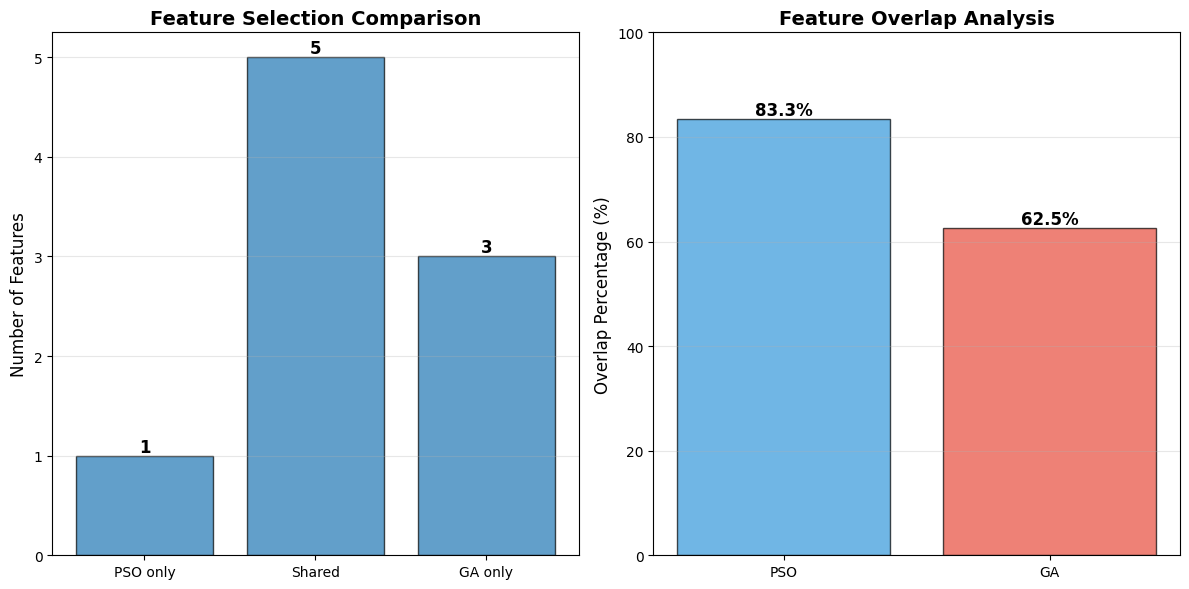

In [77]:
def analyze_important_features(pso_results, ga_results, feature_names):
    """
   Analysis of the features that each important algorithm detects
    """
    
    pso_features = set(pso_results['selected_feature_names'])
    ga_features = set(ga_results['selected_feature_names'])
    
    # Common features
    common_features = pso_features & ga_features
    
    # Unique features of each algorithm
    pso_only = pso_features - ga_features
    ga_only = ga_features - pso_features
    
    print(f"\n Summary statistics:")
    print(f" • Total number of features: {len(feature_names)}")
    print(f" • Features selected by PSO: {len(pso_features)}")
    print(f" • Features selected by GA: {len(ga_features)}")
    print(f" • Common features: {len(common_features)}")
    print(f" • PSO-only features: {len(pso_only)}")
    print(f" • GA-only features: {len(ga_only)}")
    
    
    # Common features (most important)
    print("Common features (both algorithms have identified as important):")
    if common_features:
        for i, feat in enumerate(sorted(common_features), 1):
            print(f" {i}. {feat}")
        else:
            print(" No common features selected!")

    # PSO-unique features
    print("PSO-unique features:")
    if pso_only:
        for i, feat in enumerate(sorted(pso_only), 1):
            print(f" {i}. {feat}")
        else:
            print(" No unique features")

    # GA-unique features
    print("GA-unique features:")
    if ga_only:
        for i, feat in enumerate(sorted(ga_only), 1):
            print(f" {i}. {feat}")
        else:
            print(" Has no unique attributes")
        
    plt.figure(figsize=(12, 6))
    
    # Comparison bar chart
    plt.subplot(1, 2, 1)
    categories = ['PSO only', 'Shared', 'GA only']
    counts = [len(pso_only), len(common_features), len(ga_only)]
    # colors = ['#3498db', '#2ecc71', '#e74c3c']
    
    bars = plt.bar(categories, counts, alpha=0.7, edgecolor='black')
    plt.ylabel('Number of Features', fontsize=12)
    plt.title('Feature Selection Comparison', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    
    # Add values ​​to bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Percentage chart
    plt.subplot(1, 2, 2)
    total_pso = len(pso_features)
    total_ga = len(ga_features)
    
    overlap_pso = len(common_features) / total_pso * 100 if total_pso > 0 else 0
    overlap_ga = len(common_features) / total_ga * 100 if total_ga > 0 else 0
    
    algorithms = ['PSO', 'GA']
    overlap_percentages = [overlap_pso, overlap_ga]
    
    bars = plt.bar(algorithms, overlap_percentages, color=['#3498db', '#e74c3c'], 
                   alpha=0.7, edgecolor='black')
    plt.ylabel('Overlap Percentage (%)', fontsize=12)
    plt.title('Feature Overlap Analysis', fontsize=14, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.3)
    
    # Add values
    for bar, pct in zip(bars, overlap_percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('feature_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'common': list(common_features),
        'pso_only': list(pso_only),
        'ga_only': list(ga_only)
    }

feature_analysis = analyze_important_features(pso_results, ga_results, X_train.columns)


## Convergence comparison chart

In [79]:
def plot_convergence_comparison(pso_results, ga_results):
    """
    Plotting the changes in fitness value over iterations
    """    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Direct Comparison Chart
    ax1 = axes[0, 0]
    
    pso_history = pso_results['fitness_history']
    ga_history = ga_results['fitness_history']
    
    ax1.plot(range(1, len(pso_history)+1), pso_history, 
             'o-', linewidth=2, markersize=4, 
             label='PSO', alpha=0.8)
    ax1.plot(range(1, len(ga_history)+1), ga_history, 
             's-', linewidth=2, markersize=4, 
             label='GA', alpha=0.8)
    
    ax1.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Fitness Value (Lower is Better)', fontsize=12, fontweight='bold')
    ax1.set_title('Convergence Comparison: PSO vs GA', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, max(len(pso_history), len(ga_history)) + 1)
    
    # Accuracy chart (1 - fitness)
    ax2 = axes[0, 1]
    
    # Convert fitness to approximate accuracy
    pso_accuracy = [1 - f for f in pso_history]
    ga_accuracy = [1 - f for f in ga_history]
    
    ax2.plot(range(1, len(pso_accuracy)+1), pso_accuracy, 
             'o-', linewidth=2, markersize=4, 
             label='PSO', alpha=0.8)
    ax2.plot(range(1, len(ga_accuracy)+1), ga_accuracy, 
             's-', linewidth=2, markersize=4, 
             label='GA', alpha=0.8)
    
    ax2.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Approximate Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Accuracy Improvement Over Iterations', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    # Recovery Rate Chart
    ax3 = axes[1, 0]
    
    pso_improvement = [0] + [pso_history[i-1] - pso_history[i] 
                              for i in range(1, len(pso_history))]
    ga_improvement = [0] + [ga_history[i-1] - ga_history[i] 
                             for i in range(1, len(ga_history))]
    
    ax3.plot(range(1, len(pso_improvement)+1), pso_improvement, 
             'o-', linewidth=2, markersize=4, 
             label='PSO', alpha=0.8)
    ax3.plot(range(1, len(ga_improvement)+1), ga_improvement, 
             's-', linewidth=2, markersize=4, 
             label='GA', alpha=0.8)
    
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax3.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Improvement Rate', fontsize=12, fontweight='bold')
    ax3.set_title('Fitness Improvement Rate', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    # Moving Average Chart
    ax4 = axes[1, 1]
    
    window = 5
    pso_ma = pd.Series(pso_history).rolling(window=window, min_periods=1).mean()
    ga_ma = pd.Series(ga_history).rolling(window=window, min_periods=1).mean()
    
    ax4.plot(range(1, len(pso_ma)+1), pso_ma, 
             '-', linewidth=3, 
             label=f'PSO (MA-{window})', alpha=0.8)
    ax4.plot(range(1, len(ga_ma)+1), ga_ma, 
             '-', linewidth=3, 
             label=f'GA (MA-{window})', alpha=0.8)
    
    ax4.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Moving Average Fitness', fontsize=12, fontweight='bold')
    ax4.set_title(f'Smoothed Convergence (Window={window})', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('convergence_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

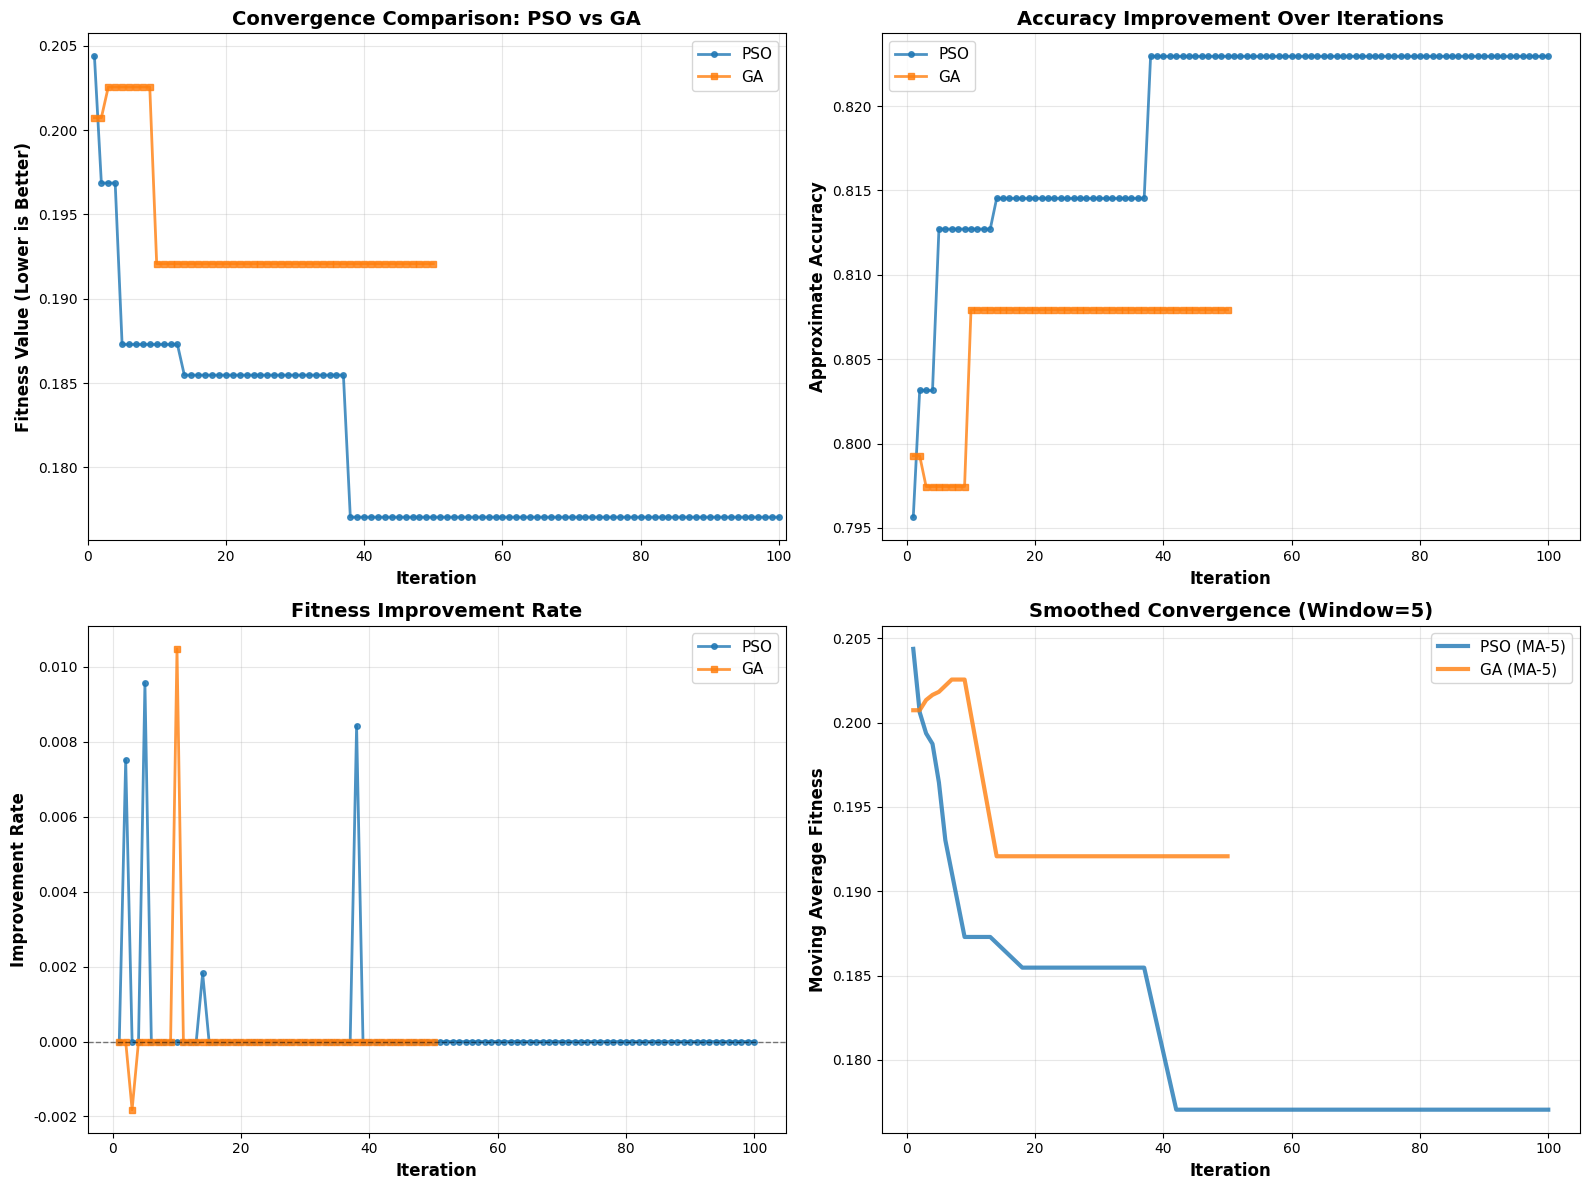

In [ ]:
plot_convergence_comparison(pso_results, ga_results)